In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from SPARQLWrapper import SPARQLWrapper
from itertools import combinations
from networkx.algorithms.matching import max_weight_matching
from pathlib import Path
from rdflib import Graph

import itertools
import time
import warnings

warnings.filterwarnings('ignore')

### Constants

In [2]:
NODE = "wd:Q171076"
NODE_URL = "http://www.wikidata.org/entity/Q171076"
NODE_FILE = f"{NODE.split(':')[1]}.ttl"

# Building the graph

In [3]:
def rdf_graph_cleaner(rdf_graph):
     # Produces a dataframe based on the RDFlib graph
    query_df = pd.DataFrame(rdf_graph, columns=["Subject", "Property", "Value"])
    # Cleaning unwanted wrappings around our objects
    query_df["Subject"] = query_df["Subject"].str.replace("rdflib.term.URIRef", "")
    query_df["Value"] = query_df["Value"].str.replace("rdflib.term.URIRef", "")
    query_df["Property"] = query_df["Property"].str.replace("rdflib.term.URIRef", "")
    discard_properties = ["P921", "P2860"]  # Properties to discard
    discard_sub_obj = ["/statement/"]  #  Subjects and Objects to discard
    query_df = query_df[~query_df.Property.str.contains('|'.join(discard_properties))]
    query_df = query_df[~query_df.Subject.str.contains('|'.join(discard_sub_obj))]
    query_df = query_df[~query_df.Value.str.contains('|'.join(discard_sub_obj))]
    # Convert dataframe to a networkx graph
    g = nx.from_pandas_edgelist(query_df, "Subject", "Value", edge_attr="Property")

    return g

In [4]:
def build_graph(node: str):
    rdf_graph_path = Path.cwd() / "rdf_graphs" / NODE_FILE
    if rdf_graph_path.is_file():
        rdf_graph_combined = Graph()
        rdf_graph_combined.parse(rdf_graph_path)
    else:
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        sparql.setQuery(f"""
                        CONSTRUCT {{ 
                        {node} ?p ?object.
                        ?object ?p1 ?subject1.
                        ?subject3 ?p4 ?object.
                        {node} wdtn:P227 ?object2.
                        ?subject5 wdtn:P227 ?object2. 
                        }} 
                        WHERE {{
                            {node} ?p ?object.
                            ?object ?p1 ?subject1.
                            ?subject3 ?p4 ?object.
                            OPTIONAL {{
                                {node} wdtn:P227 ?object2.
                                ?subject5 wdtn:P227 ?object2.}}
                            FILTER(isURI(?subject1))
                            FILTER(isURI(?object2))
                        }}
                    """)
        query_result_part1 = sparql.queryAndConvert() # Produces a RDFlib Graph object

        sparql.setQuery(f"""
                        CONSTRUCT {{ 
                        ?subject ?p2 {node}.
                        ?subject ?p5 ?subject4.
                        ?subject2 ?p3 ?subject. 
                        }} 
                        WHERE {{
                            ?subject ?p2 {node}.
                            ?subject2 ?p3 ?subject.
                            ?subject ?p5 ?subject4.
                            FILTER(isURI(?subject4))
                            MINUS{{?subject wdt:P31 wd:Q13442814}}
                            MINUS{{?subject wdt:P31 wd:Q1348305}}
                        }}
                    """)
        query_result_part2 = sparql.queryAndConvert() # Produces a RDFlib Graph object

        rdf_graph_combined = query_result_part1
        for trbl in query_result_part2:
            rdf_graph_combined.add(trbl)

        rdf_graph_combined.serialize(destination=rdf_graph_path)

    return rdf_graph_cleaner(rdf_graph_combined)

In [5]:
q171076_graph = build_graph(NODE)

# Identifier heuristic

In [6]:
def identifier(graph: object, node: str):
    common_id = {}

    for item in graph.neighbors(node):
        property = graph[node][item]["Property"]
        if property == "http://www.wikidata.org/prop/direct-normalized/P227": 
            for item_neighbor in graph.neighbors(item):
                if item_neighbor == node:
                    continue
                else:
                    property2 = graph[item][item_neighbor]["Property"]
                    if property2 == property:
                        common_id[property] = item_neighbor
    return common_id

In [7]:
identifier(q171076_graph, NODE_URL)

{'http://www.wikidata.org/prop/direct-normalized/P227': 'http://www.wikidata.org/entity/Q338712'}

# Neighborhood heuristic

In [8]:
def common_neighbors(graph: object, node: str):
    nodes_to_skip = ["http://www.w3.org/ns/lemon/ontolex#LexicalSense", "http://wikiba.se/ontology#BestRank", "http://wikiba.se/ontology#NormalRank"]
    node_dict = {}

    for item in graph.neighbors(node):
        for neighbor in graph.neighbors(item):
            if neighbor == node or neighbor in nodes_to_skip or item == node:
                continue
            common_neighbors = sum(n in graph.neighbors(neighbor) for n in graph.neighbors(node))
            node_dict[neighbor] = common_neighbors
    return sorted(node_dict.items(), key=lambda item: item[1], reverse=True)        

In [9]:
com_neighbors = common_neighbors(q171076_graph, NODE_URL)    

# RoleSim

#### Iceberg pruning constants

In [10]:
THETA = 0.5
ALPHA = 0.4
BETA = 0.3
THETA_BAR = (THETA - BETA)/(1 - BETA)
DELTA = 0.01

#### sort_nodes_by_degree

In [11]:
def sort_nodes_by_degree(graph):
    unsorted_degrees = []
    unsorted_nodes = []

    for node in list(graph.nodes):
        unsorted_nodes.append(node)
        unsorted_degrees.append(graph.degree(node))

    sorted_node_degree_by_index = np.argsort(-np.array(unsorted_degrees), kind ='mergesort')
    sorted_nodes_by_degree = np.array(unsorted_nodes)[sorted_node_degree_by_index]

    return sorted_nodes_by_degree

#### sort_neighborhood_degree

In [12]:
def sort_neighborhood_degree(sorted_nodes, graph):
    neighbor_degree_sorted_dict = {}

    for node in sorted_nodes:
        neighbors = list(graph.neighbors(node))
        neighbor_degrees = [graph.degree(n) for n in neighbors]
        sorted_neighbor_degrees_by_index = np.argsort(neighbor_degrees, kind ='mergesort')
        sorted_neighbors = np.array(neighbors)[sorted_neighbor_degrees_by_index]
        sorted_neighbor_degrees = np.array(neighbor_degrees)[sorted_neighbor_degrees_by_index]
        neighbor_degree_sorted_dict[node] = (sorted_neighbors, sorted_neighbor_degrees)

    return neighbor_degree_sorted_dict

#### get_maximal_matching_weight

In [13]:
def get_maximal_matching_weight(graph, node_u, node_v, neighbor_degree_sorted_dict):
    neighbors_u = list(neighbor_degree_sorted_dict[node_u][0])
    neighbors_v = list(neighbor_degree_sorted_dict[node_v][0])
    combined = [neighbors_u, neighbors_v]
    all_possible_edges = list(itertools.product(*combined))
    subgraph = nx.Graph()

    for edge in all_possible_edges:
        if graph.has_edge(*edge):
            subgraph.add_edge(*edge)

    weight = max_weight_matching(subgraph)
    return weight

#### Permutation

In [14]:
def permutations(sorted_node_list):
    comb = combinations(sorted_node_list, 2)
    return comb

#### Creating Initial Similarity Matrix using Pruned Combinations

In [15]:
def initialize_similarity_matrix(comb, graph, neighbor_degree_sorted_dict):
    pruned_by_one = 0
    pruned_by_two = 0
    pruned_by_three = 0

    similarity_temp_graph_iceberg = nx.Graph()

    # Begin the process of pruning using the Iceberg idea
    for i in list(comb):
        node_u = i[0]
        node_v = i[1]

        # Rule 1
        if (THETA_BAR*graph.degree(node_u) > graph.degree(node_v)) or (graph.degree(node_v) > graph.degree(node_u)):
            pruned_by_one += 1
            continue
        else :
            # Rule 3
            neighbor_1_degree_u = neighbor_degree_sorted_dict[node_u][1][0]
            neighbor_1_degree_v = neighbor_degree_sorted_dict[node_v][1][0]
            m11 = (1 - BETA) * (min(neighbor_1_degree_u, neighbor_1_degree_v) / max(neighbor_1_degree_u, neighbor_1_degree_v)) + BETA
            if neighbor_1_degree_v <= neighbor_1_degree_u and ((graph.degree(node_v) - 1 + m11) < (THETA_BAR*graph.degree(node_u))):
                pruned_by_three += 1
                continue

        # Rule 2
        maximal_matching_weight = len(get_maximal_matching_weight(graph, node_u, node_v, neighbor_degree_sorted_dict))
        if maximal_matching_weight >= THETA_BAR*graph.degree(node_u):
            similarity_initial_value = (1 - BETA) * (maximal_matching_weight/graph.degree(node_u)) + BETA
            similarity_temp_graph_iceberg.add_edge(node_u, node_v, weight=similarity_initial_value)
        else:
            pruned_by_two += 1

    print(pruned_by_one, ' nodes were pruned by rule 1.')
    print(pruned_by_two, ' nodes were pruned by rule 2.')
    print(pruned_by_three, ' nodes were pruned by rule 3.')

    return similarity_temp_graph_iceberg

#### Auxiliary

In [16]:
def auxiliary(graph, similarity_temp_graph_iceberg):
    # Attempting a graph-based architecture for processing iterations of RoleSim. Required deep-copy of graph.
    final_similarity_iceberg_graph = nx.Graph(similarity_temp_graph_iceberg)
    list_of_nodes_selected = list(final_similarity_iceberg_graph.nodes)

    skipped_present_edges = 0
    for edgepair in combinations(list_of_nodes_selected, 2):
        u = edgepair[0]
        v = edgepair[1]
        if final_similarity_iceberg_graph.has_edge(*edgepair):
            skipped_present_edges+=1
        else:
            degree_u = graph.degree(u)
            degree_v = graph.degree(v)
            denominator = max(degree_u, degree_v)
            numerator = min(degree_u, degree_v)
            weight_of_edgepair = (ALPHA * (1 - BETA)* (numerator / denominator) ) + BETA
            final_similarity_iceberg_graph.add_edge(*edgepair, weight=weight_of_edgepair)

    return final_similarity_iceberg_graph, list_of_nodes_selected

#### All maximal matching

In [17]:
def all_maximal_matchings(subgraph):
    maximal_matchings = []
    partial_matchings = [{(u,v)} for (u,v) in subgraph.edges()]

    while partial_matchings:
        # get current partial matching
        m = partial_matchings.pop()
        nodes_m = set(itertools.chain(*m))

        extended = False
        for (u,v) in subgraph.edges():
            if u not in nodes_m and v not in nodes_m:
                extended = True
                # copy m, extend it and add it to the list of partial matchings
                m_extended = set(m)
                m_extended.add((u,v))
                partial_matchings.append(m_extended)

        if not extended and m not in maximal_matchings:
            maximal_matchings.append(m)

    return maximal_matchings

#### Convergence

In [18]:
def check_if_converged_graph(current_iteration, previous_iteration):
    current_sum = current_iteration.size(weight='weight')
    previous_sum = previous_iteration.size(weight='weight')
    diff = np.fabs(current_sum - previous_sum)
    if diff > (0.01 *current_iteration.number_of_edges()):
        return True
    else:
        return False


#### Get maximum weight

In [19]:
def get_maximum_weight(previous_iteration, node_u, node_v, neighbor_degree_sorted_dict, list_of_nodes_selected_sorted):
    neighbors_u = list(neighbor_degree_sorted_dict[node_u][0])
    neighbors_v = list(neighbor_degree_sorted_dict[node_v][0])

    neighbors_u = list(set(neighbors_u) & set(list_of_nodes_selected_sorted))
    neighbors_v = list(set(neighbors_v) & set(list_of_nodes_selected_sorted))

    combined = [neighbors_u, neighbors_v]
    all_possible_edges = list(itertools.product(*combined))
    subgraph = nx.Graph()
    degree_u = len(neighbors_u)
    degree_v = len(neighbors_v)

    for edge in all_possible_edges:
        if edge[0] != edge[1]:
            node_x = edge[0]
            node_y = edge[1]
            subgraph.add_edge(*edge, weight = previous_iteration[node_x][node_y]['weight'])

    trialing_using_nx_max_matching = True
    if trialing_using_nx_max_matching:
        maximal_matching_possibilities = [max_weight_matching(subgraph)]
    else:
        maximal_matching_possibilities = all_maximal_matchings(subgraph)

    maximum_weight_of_all = 0
    for possibility in maximal_matching_possibilities:
        current_weight = 0
        for edge in possibility:
            current_weight += subgraph[edge[0]][edge[1]]['weight']
        if current_weight >= maximum_weight_of_all:
            maximum_weight_of_all = current_weight

    if degree_u == 0 and degree_v == 0:
        maximum_weight_value = 0
    else:
        maximum_weight_value = maximum_weight_of_all/max(degree_u, degree_v)
        
    return maximum_weight_value

#### Iterative RoleSim Alg

In [20]:
def rolesim(iterative_rolesim_graph_initial, list_of_nodes_selected_sorted, neighbor_degree_sorted_dict):
    '''
    The code uses the edge weights of an undirected networkX graph to store the similarity values between nodes.
    Thus, every node is connected to every other node in this graph, and if there are n nodes, then there are
    combination(n, 2) edges (every possible edge)
    '''
    current_iteration = nx.Graph(iterative_rolesim_graph_initial)
    previous_iteration = nx.Graph(iterative_rolesim_graph_initial)

    k = 0

    initial_iteration = True
    while initial_iteration == True or check_if_converged_graph(current_iteration, previous_iteration):
        initial_iteration = False
        k = k+1
        previous_iteration = nx.Graph(current_iteration)
        print('--------------------')
        print('Iteration ', k)
        print('--------------------')
        print('Previous_iteration')
        print(list(previous_iteration.edges(data=True))[:4])

        start_time = time.time()
        for edge in list(current_iteration.edges):
            node_u = edge[0]
            node_v = edge[1]
            current_iteration[node_u][node_v]['weight'] = (1-BETA) *get_maximum_weight(previous_iteration, node_u, node_v, neighbor_degree_sorted_dict, list_of_nodes_selected_sorted) + BETA

        elapsed_time = time.time() - start_time
        print('Current_iteration')
        print(list(current_iteration.edges(data=True))[:4])
        print('Elapsed time ', elapsed_time)
        print('--------------------')

    print('Ended after ', k, ' iterations')
    print('Final iteration')
    print(list(current_iteration.edges(data=True))[:4])

    return current_iteration

# MAIN Function calls

In [21]:
print(f"Initial Graph Size: nodes({len(q171076_graph.nodes())}), edges({len(q171076_graph.edges())})")
q171076_graph.remove_nodes_from(list(nx.isolates(q171076_graph)))
sorted_nodes_by_degree = sort_nodes_by_degree(q171076_graph)

Initial Graph Size: nodes(684), edges(694)


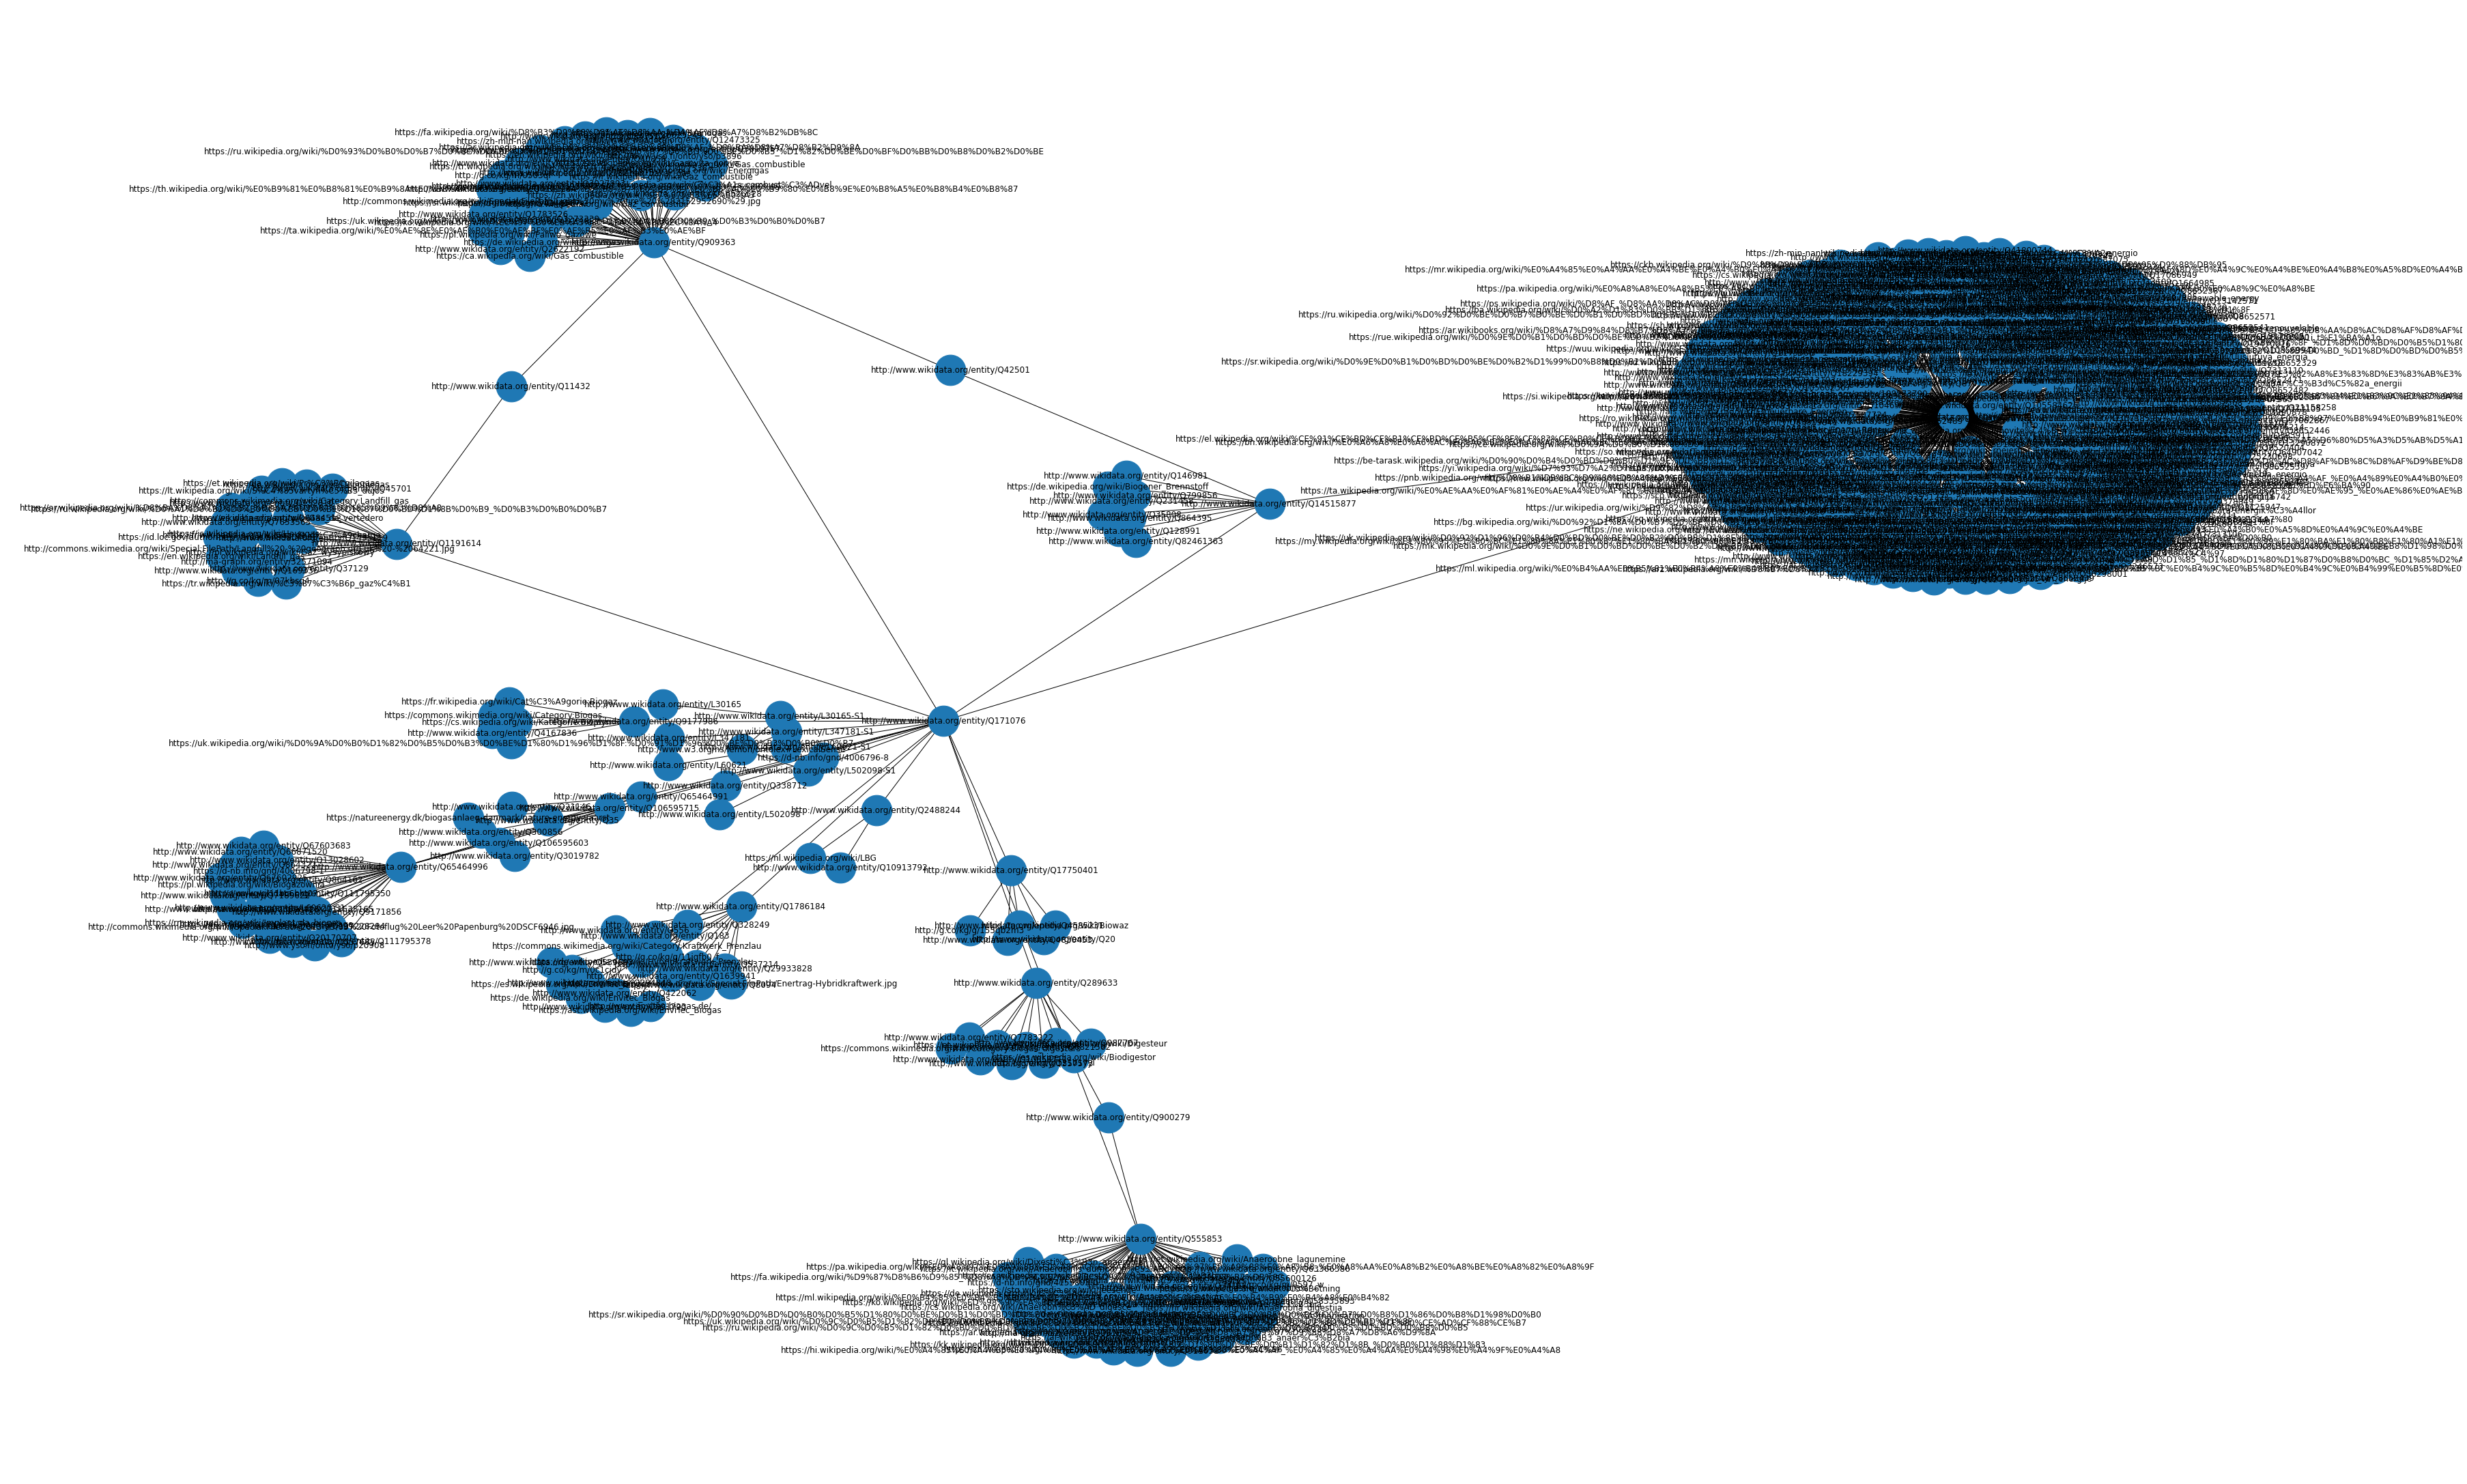

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50,30))
nx.draw(q171076_graph, with_labels=True, node_size=2000)

In [24]:
neighbor_degree_dict = sort_neighborhood_degree(sorted_nodes_by_degree, q171076_graph)
#print(neighbor_degree_dict)

In [25]:
similarity_temp_graph_iceberg = initialize_similarity_matrix(permutations(sorted_nodes_by_degree), q171076_graph, neighbor_degree_dict)
#print(similarity_temp_graph_iceberg)

10030  nodes were pruned by rule 1.
215249  nodes were pruned by rule 2.
46  nodes were pruned by rule 3.


In [26]:
aux, nodes = auxiliary(q171076_graph, similarity_temp_graph_iceberg)
#print(aux, nodes)

In [27]:
r_sim = rolesim(nx.Graph(aux), sorted(nodes), neighbor_degree_dict)

--------------------
Iteration  1
--------------------
Previous_iteration
[('http://www.w3.org/ns/lemon/ontolex#LexicalSense', 'http://www.wikidata.org/entity/L30165-S1', {'weight': 0.825}), ('http://www.w3.org/ns/lemon/ontolex#LexicalSense', 'http://www.wikidata.org/entity/L60621-S1', {'weight': 0.825}), ('http://www.w3.org/ns/lemon/ontolex#LexicalSense', 'http://www.wikidata.org/entity/L502098-S1', {'weight': 0.825}), ('http://www.w3.org/ns/lemon/ontolex#LexicalSense', 'http://www.wikidata.org/entity/L347181-S1', {'weight': 0.825})]
Current_iteration
[('http://www.w3.org/ns/lemon/ontolex#LexicalSense', 'http://www.wikidata.org/entity/L30165-S1', {'weight': 0.5377083333333333}), ('http://www.w3.org/ns/lemon/ontolex#LexicalSense', 'http://www.wikidata.org/entity/L60621-S1', {'weight': 0.5377083333333333}), ('http://www.w3.org/ns/lemon/ontolex#LexicalSense', 'http://www.wikidata.org/entity/L502098-S1', {'weight': 0.5377083333333333}), ('http://www.w3.org/ns/lemon/ontolex#LexicalSense', 

In [28]:
temp = nx.to_pandas_edgelist(r_sim)
#temp.loc[temp.source == NODE_URL].sort_values(by=["weight"], ascending=False)
temp.sort_values(by=["weight"], ascending=False).head(15)

,source,target,weight
164060,http://www.wikidata.org/entity/Q338712,https://d-nb.info/gnd/4006796-8,0.82850
4121,http://www.wikidata.org/entity/Q35,http://www.wikidata.org/entity/L60621,0.75990
4115,http://www.wikidata.org/entity/Q35,http://www.wikidata.org/entity/L502098,0.75990
63927,http://www.wikidata.org/entity/L60621,http://www.wikidata.org/entity/Q21146,0.75990
47078,http://www.wikidata.org/entity/L30165,http://www.wikidata.org/entity/Q21146,0.75990
112287,http://www.wikidata.org/entity/Q10913792,http://www.wikidata.org/entity/Q21146,0.75990
4570,http://www.wikidata.org/entity/Q35,http://www.wikidata.org/entity/L347181,0.75990
4297,http://www.wikidata.org/entity/Q35,https://nl.wikipedia.org/wiki/LBG,0.75990
145410,http://www.wikidata.org/entity/Q21146,https://nl.wikipedia.org/wiki/LBG,0.75990
4213,http://www.wikidata.org/entity/Q35,http://www.wikidata.org/entity/Q10913792,0.75990
